# ResNet-D Constructor
### В пайплайне используется контруктор ResNetD сетей и некоторые трюки, взятые из статьи [Bag of Tricks](https://arxiv.org/pdf/1812.01187.pdf)
#### Загрузка и просмотр датасета лежат в [этом ноутбуке](ResNet_constructor.ipynb) 
- Accuracy на тестовом датасете составляет 94.2%

### Oсновые блоки
[Загрузка датасета](#Загрузка-датасета) <br>
[Гиперпараметры обучения](#Гиперпараметры-обучения) <br>
[Просмотр датасета](#Просмотр-датасета) <br>
[Создание модели](#Создание-модели) <br>
[Тренировочный цикл](#Тренировочный-цикл) <br>
[Проверка модели](#Проверка-модели) <br>
[Критика](#Критика)

In [1]:
import time
import warnings
import os

import IPython
import numpy as np
import pandas as pd
import torch
from torch import nn
from torchvision import transforms, datasets, utils
from fastai.vision.all import untar_data, URLs

from modules import datasets_loader, CNN_constructor, train_tools

warnings.filterwarnings('ignore')

### Загрузка датасета

In [2]:
dataset_path = '../imagenette/imagenette2-320/'
datasets_loader.imagenette_loader(dataset_path)

- eсли нужно установить fastai, то можете использовать команду <br>
'conda install -c fastai -c pytorch fastai'

## Гиперпараметры обучения

In [3]:
# hyper params
batch_size = 32
num_epoch = 405
optimizer_type = 'Ranger' # 'SGD' or 'Adam' or 'AdamW' or 'RAdam' or 'Ranger'
optimizer_kwargs = {} # only for Ranger 'use_gc': True
label_smoothing = 0.1 # 0 for disable label_smoothing
activation = 'mish' # 'relu' or 'sigmoid' or 'swish'

# neural network architecture
resnet_layers = [3, 4, 6, 3]
bottleneck = True
num_classes = 10
resnet_type = 'D'
attention = False

# learning rate
learning_rate = 0.001 # 0.1 * batch_size / 256
warmup_epoch = 5
scheduler_type = 'cos'
cosine_cycles = 2
decay_steps = 5

# misc
save_best_model = True
save_model_dir = './models/'
metrics_dir = './metrics/'
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

torch.set_num_threads(8)

### Гиперпараметры_обучения
- batch_size: кол-во изображений в одном батче. Предел зависит от кол-ва памяти на видеокарте
- num_epoch: кол-во эпох обучения. Желательно добавлять к плановому количеству warmup_epoch
- optimizer_type: тип оптимизатора, использующегося для обновления весов сети. Может быть 'SGD' или 'Adam'
- label_smoothing: параметр сдвига целевой вероятности (epsilon). Подробности в статье Bag of Tricks

<b>Архитектура сети:
 - layers: список с количеством стандартных блоков по слоям
 - bottleneck: определяет использование стандартных блоков или 'bottleneck' блоков 
 - num_classes: количество предсказываемых классов<br>
(!) Сеть ожидает на вход изображение с разрешением 224х224х3

<b>Изменения скорости обучения
 - learning_rate: базовая скорость обучения
 - warmup_epoch: количество эпох, в течении которых происходит увеличение скорости обучения с 0 до базового значения

Реализовано две стратегии 'cos' - согласно функции косинуса и 'step' - ступенчатое уменьшение скорости обучения в 10 раз через равные промежутки.
- sheduler_type: задает стратегию изменения скорости обучения в течении обучения. может быть 'cos' или 'step'
- cosine_cycles: задает кол-во циклов изменения learning rate при косинусном уменьшении ('cos'). Должно быть меньше или равно num_epoch.<br> 
- decay_steps: количество шагов уменьшения learning rate при ступенчатом уменьшении ('step'). Должно быть меньше или равно num_epoch.<br> 

<b>Прочее
- save_best_model: нужно ли сохранять лучшую модель в процессе обучения. False приведет к сохранению модели в конце обучения
- save_model_dir: путь к папке, в которую сохраняются модели
- save_metrics_dir: путь к папке, в которую сохраняются метрики обучения
- dataset_path: путь к папке с датасетом

### Примеры стандартных сетей:<br>
<b>ResNet-18: </b> <br> 
model = ResNet_like(layers=[2, 2, 2, 2], bottleneck=False, num_classes=10)

<b>ResNet-34: </b> <br> 
model = ResNet_like(resnet_layers=[3, 4, 6, 3], bottleneck=False, num_classes=10)

<b>ResNet-50: </b> <br> 
model = ResNet_like(resnet_layers=[3, 4, 6, 3], bottleneck=True, num_classes=10)

<b>ResNet-101: </b> <br> 
model = ResNet_like(resnet_layers=[3, 4, 23, 3], bottleneck=True, num_classes=10)

<b>ResNet-152: </b> <br> 
model = ResNet_like(resnet_layers=[3, 8, 36, 3], bottleneck=True, num_classes=10)

#### Примеры пользовательских архитектур:<br>
<b>ResNet-11: </b> <br> 
model = ResNet_like(layers=[3, 3, 3], bottleneck=False, num_classes=10)
    
<b>ResNet-42: </b> <br> 
model = ResNet_like(layers=[3, 5, 9, 3], bottleneck=False, num_classes=10)
    
<b>ResNet-74: </b> <br>
model = ResNet_like(layers=[3, 4, 6, 8, 3], bottleneck=True, num_classes=10)

---

<b>Название модели</b><br>
Создаем название модели, которое будет фигурировать в названии сохраненных файлов метрики и модели<br>
Название модели является производным от гиперпараметров

In [4]:
m = 3 if bottleneck else 2
n = cosine_cycles if scheduler_type == 'cos' else decay_steps
model_name = f'ResNet{sum(resnet_layers)*m + 2}_{optimizer_type}_{activation}_lr{learning_rate}_b{batch_size}_{scheduler_type}_sc{(num_epoch-warmup_epoch)//n}'
print(f'model name is {model_name}')

model name is ResNet50_Ranger_mish_lr0.001_b32_cos_sc200


### Просмотр датасета

Посмотрим csv, приложенный к датасету

In [5]:
labels_df = pd.read_csv(dataset_path + '/noisy_imagenette.csv')
labels_df.head()

,path,noisy_labels_0,noisy_labels_1,noisy_labels_5,noisy_labels_25,noisy_labels_50,is_valid
0,train/n02979186/n02979186_9036.JPEG,n02979186,n02979186,n02979186,n02979186,n02979186,False
1,train/n02979186/n02979186_11957.JPEG,n02979186,n02979186,n02979186,n02979186,n03000684,False
2,train/n02979186/n02979186_9715.JPEG,n02979186,n02979186,n02979186,n03417042,n03000684,False
3,train/n02979186/n02979186_21736.JPEG,n02979186,n02979186,n02979186,n02979186,n03417042,False
4,train/n02979186/ILSVRC2012_val_00046953.JPEG,n02979186,n02979186,n02979186,n02979186,n03394916,False


В приложенном датасете указаны пути к картинкам и их лейблы. <br>
Цифра после noisy_labels_ означает уровень зашумленности правильных ответов, т.е. noisy_labels_25 означает, что 25% правильных ответов - неправильные.

В этом ноутбуке мы будем работать без зашумления правильных ответов, т.е. нас интересует колонка 'noisy_labels_0'. <br>
Давайте посмотрим сколько уникальных классов находится в этом датасете.

In [6]:
print('Unique labels in Imagenette is', len(labels_df['noisy_labels_0'].unique()))

Unique labels in Imagenette is 10


Количество картинок в тренировочном датасете

In [7]:
train_img_qty = len(labels_df[labels_df['is_valid'] == False].index)
print(f'Image in train dataset: {train_img_qty}')

Image in train dataset: 9469


Кол-во картинок в тестовом датасете

In [8]:
test_img_qty = len(labels_df[labels_df['is_valid'] == True].index)
print(f'Image in test dataset: {test_img_qty}')

Image in test dataset: 3925


Давайте глянем на примеры картинок в тренировочном датасете

gas pump


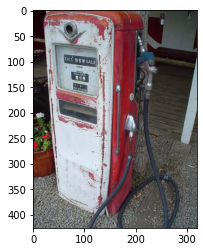

parachute


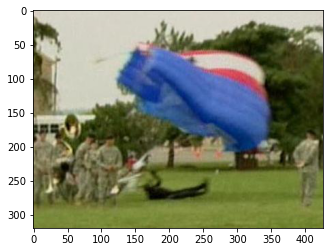

English springer


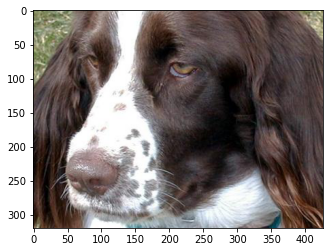

English springer


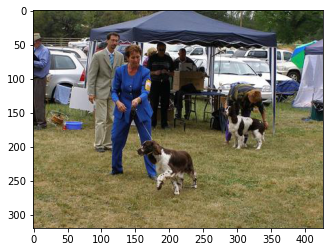

In [9]:
show_subset = datasets.ImageFolder(root=dataset_path + '/train/', transform=transforms.Compose([transforms.ToTensor()]))
show_subset = torch.utils.data.Subset(show_subset, np.random.randint(0, high=len(show_subset), size=4))
show_subset_loader = torch.utils.data.DataLoader(show_subset, shuffle=False)
for images, labels in show_subset_loader:
    print(datasets_loader.label_func(int(labels)))
    datasets_loader.visualize_tensor(utils.make_grid(images))

### Предобработка данных

В качестве аугментаций ипользуются:
- вырезание из картинки случайного прямоугольника общей площадью не менее 8% от исходного изображения.
- случайного изменение освещенности, констраста, насыщенности и тона
- случайный переворот изображения по горизонтальной оси
- нормализация

Для тестового датасета используется:
- изменение размера под вход сети
- нормализация

In [10]:
resolution = (14*2**len(resnet_layers), 14*2**len(resnet_layers))

train_transform = transforms.Compose([
        transforms.RandomResizedCrop(resolution, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333)),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
        transforms.RandomHorizontalFlip(.5),
        transforms.RandomVerticalFlip(.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
test_transform = transforms.Compose([
        transforms.Resize(resolution),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

Создаем тренировочный и тестовый датасет и DataLoader'ы к ним

In [11]:
trainset = datasets.ImageFolder(root=dataset_path + 'train/', transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = datasets.ImageFolder(root=dataset_path + 'val/', transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, shuffle=False)

## Создание модели

Инициализируем модель с через конструктор. <br>

In [12]:
model = CNN_constructor.ResNetLike(layers=resnet_layers, 
                                   resnet_type=resnet_type, 
                                   bottleneck=bottleneck, 
                                   num_classes=num_classes,
                                   activation=activation,
                                   self_attention=attention)

Задаем функцию ошибки. <br>
Задаем оптимизатор. <br>
Задаем планировщики скорости обучения. <br>

In [13]:
criterion = train_tools.SmoothCrossEntropyLoss(smoothing=label_smoothing)
optimizer = train_tools.get_optimizer(model, optimizer_type, learning_rate, **optimizer_kwargs)
scheduler = train_tools.get_scheduler(optimizer, scheduler_type, step_size=num_epoch//decay_steps, cycle_len=num_epoch//cosine_cycles)
if warmup_epoch:
    scheduler_warmup = train_tools.get_scheduler(optimizer, 
                                                 'warmup', 
                                                 learning_rate=learning_rate, 
                                                 batch_per_epoch=len(trainloader), 
                                                 warmup_epoch=warmup_epoch)

Загружаем модель на видеокарту.

In [14]:
model.to(device)

ResNetLike(
  (first): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (body): Sequential(
    (block_2_1): ResNetBottleneckBlock(
      (activation): Mish()
      (downsample_block): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64,

Создадим папки для сохранения моделей и метрик

In [15]:
datasets_loader.create_dir(save_model_dir)
datasets_loader.create_dir(metrics_dir)

Создаем датафрейм для записи метрик обучения. <br>
Датафрейм сохраняется в папку './metrics'

In [16]:
cols_name = ['epoch', 'time', 'current_lr', 'loss', 'accuracy_train', 'accuracy_val']
metrics_frame = pd.DataFrame(columns=cols_name)
metrics_frame_file = (metrics_dir + model_name + '.csv')
print(f'File with train metrics save to {metrics_frame_file}')

File with train metrics save to ./metrics/ResNet50_Ranger_mish_lr0.001_b32_cos_sc200.csv


## Тренировочный цикл

- Основная метрика accuracy (топ1).<br>
- В цикле используется упрощенный подсчет accuracy в конце каждой эпохи для ускорения обучения.<br>
Если в конце эпохи ускоренный подсчет показывает интересный результат, то метрика на тестовом датасете будет пересчитана честно.
- Сохранение модели

In [ ]:
for epoch in range(num_epoch):  # loop over the dataset multiple times 
    # train cycle
    model.train()
    start_time = time.time()
    for data in trainloader:
        loss, outputs = train_tools.make_step(data, optimizer, model, criterion, device)
        if epoch < warmup_epoch:
            scheduler_warmup.step()
    if epoch >= warmup_epoch:
        scheduler.step()
    
    # metrics calc
    model.eval()
    accuracy_train = train_tools.approx_accuracy(trainloader, model, device, fraction=.08)
    accuracy_val = train_tools.approx_accuracy(testloader, model, device, fraction=.25)
    
    if accuracy_val >= .88 and accuracy_val >= metrics_frame['accuracy_val'].max():
        accuracy_val = train_tools.true_accuracy(testloader, model, device)

    end_time = time.time()
    metrics = {'epoch': epoch+1,
               'time': end_time - start_time,
               'current_lr': [group['lr'] for group in optimizer.param_groups][0],
               'loss': float(loss),
               'accuracy_train': accuracy_train,
               'accuracy_val': accuracy_val,
               }
    
    if metrics['epoch'] % 10 == 0: # needs for decrease outputs
        IPython.display.clear_output()
    print("Epoch {}/{}, Time: {:.2f} sec, current_lr: {:.2e}, Loss: {:.3f}, Accuracy_train: {:.3f}, Accuracy_val: {:.3f}".
          format(metrics['epoch'], num_epoch, metrics['time'], metrics['current_lr'], metrics['loss'], metrics['accuracy_train'], metrics['accuracy_val']))
    
    metrics_frame = metrics_frame.append(pd.DataFrame.from_dict(metrics, orient='index').T)
    metrics_frame.to_csv(metrics_frame_file, index=False)
    
    if save_best_model:
        if metrics['accuracy_val'] == metrics_frame['accuracy_val'].max():
            torch.save(model, save_model_dir + model_name + '.pt')
if not save_best_model:
    torch.save(model, save_model_dir + model_name + '.pt')

Epoch 180/405, Time: 199.30 sec, current_lr: 4.34e-05, Loss: 0.611, Accuracy_train: 0.946, Accuracy_val: 0.936
Epoch 181/405, Time: 202.03 sec, current_lr: 4.03e-05, Loss: 0.709, Accuracy_train: 0.974, Accuracy_val: 0.936
Epoch 182/405, Time: 157.64 sec, current_lr: 3.73e-05, Loss: 0.750, Accuracy_train: 0.966, Accuracy_val: 0.933
Epoch 183/405, Time: 157.48 sec, current_lr: 3.44e-05, Loss: 0.665, Accuracy_train: 0.967, Accuracy_val: 0.934
Epoch 184/405, Time: 157.37 sec, current_lr: 3.16e-05, Loss: 0.685, Accuracy_train: 0.964, Accuracy_val: 0.928
Epoch 185/405, Time: 158.34 sec, current_lr: 2.90e-05, Loss: 0.622, Accuracy_train: 0.958, Accuracy_val: 0.929
Epoch 186/405, Time: 158.98 sec, current_lr: 2.64e-05, Loss: 0.644, Accuracy_train: 0.972, Accuracy_val: 0.936
Epoch 187/405, Time: 160.40 sec, current_lr: 2.40e-05, Loss: 0.589, Accuracy_train: 0.966, Accuracy_val: 0.936
Epoch 188/405, Time: 202.30 sec, current_lr: 2.17e-05, Loss: 0.655, Accuracy_train: 0.964, Accuracy_val: 0.937
E

### Проверка модели

Посмотрим сохраненные в процессе обучения метрики

In [22]:
metrics_frame.tail()

,epoch,time,current_lr,loss,accuracy_train,accuracy_val
0,401.0,200.987605,3.865064e-06,0.681272,0.981506,0.940892
0,402.0,156.460516,2.960085e-06,0.627560,0.986790,0.936799
0,403.0,156.846505,2.175326e-06,0.590562,0.972259,0.940877
0,404.0,200.076990,1.510978e-06,0.593740,0.973580,0.939363
0,405.0,155.465932,9.672014e-07,0.558377,0.980185,0.929664


Посмотрим лучший результат на валидации

In [23]:
metrics_frame[metrics_frame['accuracy_val'] == metrics_frame['accuracy_val'].max()]

,epoch,time,current_lr,loss,accuracy_train,accuracy_val
0,365.0,199.337118,0.000113,0.636967,0.977543,0.94242


Проверим сохраненную модель на соответствие метрикам в процессе обучения.

In [24]:
model = torch.load(save_model_dir + model_name + '.pt')
model = model.eval()

In [25]:
accuracy_check = train_tools.true_accuracy(testloader, model, device)

print(f'Accuracy saved model on the validation dataset is: {accuracy_check:.3f}')

Accuracy saved model on the validation dataset is: 0.942


<b> Использование warmup, аугментаций из статьи и функции активации swish увеличило средний результат на 1,0 % <br>
    Использование оптимизатора Restricted Adam увеличило средний результат на 0,7 % <br>
    Использование Ranger (LookAhead) увеличило средний результат на 0,2 %

### Критика

Известные проблемы:
- результат все еще ниже baseline от fastai на 1 пункт
- агументации сильно увеличивают время обучения
- результат очень сильно зависит от стартового learning_rate. learning_rate для используемых оптимизаторов нужно выбирать в разном диапазоне (0,01-0,1 для SGD и 0,0005-0,03 для Adam), что приводит к некоторой путанице
- метрика, посчитанная при проверке модели может отличаться от сохраненной в процессе обучения <br>
Это происходит если в процессе обучения метрика считается только с помощью approx_accuracy()
- увеличение количества гиперпараметров усложняет поиск оптимальных значений
- разброс результатов в разных запусках при идентичных гиперпараметрах составляет +/- 0,4%

# 